## Exe 1 - MACHINE LEARNING : DECISION TREES

## Problem description
We will use an example problem to demostrate the use of Decision trees for classification. The example problem is from the [Titanic Survival competition](https://www.kaggle.com/c/titanic). The [dataset](https://www.kaggle.com/c/titanic/data)  is also from the [Titanic Survival competition](https://www.kaggle.com/c/titanic). 
We will use some of the passengers' information, such as name, sex, age, ticket class, cabin number, etc, to predict if the passenger can survival from the disaster.

## Gather the Data
Here we only use the train dataset provided on kaggle for demostration. Below I have listed the features with a short description:

-   `PassengerId` is the unique id of the row and it doesn't have any effect on target
-   `Survived` is the target variable we are trying to predict (**0** or **1**):
    -   **1 = Survived**
    -   **0 = Not Survived**
-   `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**, **2** or **3**):
    -   **1 = Upper Class**
    -   **2 = Middle Class**
    -   **3 = Lower Class**
-   `Name`, `Sex` and `Age` are self-explanatory
-   `SibSp` is the total number of the passengers' siblings and spouse
-   `Parch` is the total number of the passengers' parents and children
-   `Ticket` is the ticket number of the passenger
-   `Fare` is the passenger fare
-   `Cabin` is the cabin number of the passenger
-   `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    -   **C = Cherbourg**
    -   **Q = Queenstown**
    -   **S = Southampton**

In [1]:
import pandas as pd
train_df = pd.read_csv('train.csv')
display(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Exploratory data analysis

First, we use sweetviz to generate a self-contained HTML report to know the fundermental infomation about the dataset.

In [2]:
import sweetviz as sv
#train_report = sv.analyze(train_df)
train_report = sv.analyze(train_df,'Survived')
train_report.show_html()

:FEATURES DONE:                    |█████████████████████| [100%]   00:02  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)
Creating Associations graph... DONE!
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


From the SWEETVIZ_REPORT.html, we can know the three columns in the dataset: **PassengerId**,**Ticket**,**Name** are contains the info similar as ID for a passenger. It is not very useful for data analysis. So we remove them from the dataset first.
And the cabin number also have too many distinct values. Here we add a new column called **cabin_area** to just keep the area infomation from the cabin number

In [3]:
df =train_df.drop(['PassengerId','Ticket','Name','Cabin'],axis=1)
df['cabin_code']=train_df['Cabin'].str[:1]
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_code
0,0,3,male,22.0,1,0,7.2500,S,NaN
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,NaN
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,NaN
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,NaN
887,1,1,female,19.0,0,0,30.0000,S,B
888,0,3,female,NaN,1,2,23.4500,S,NaN
889,1,1,male,26.0,0,0,30.0000,C,C


Next, we will find the **correlation** between the **survived** info and each other features(columns).
We use an utility function to generate the barcharts to visualize the correlation.

In [4]:
# utility function to show the features
def drawstackchart(dataset, group_col, value_col = 'Survived', labels = ["Not Survived", "Survived"], 
                   sort = False , fsize = 12, maxgroup=10, 
                   bins = None, navalue=np.inf,
                   ax=None, title= None, titlepos=(0.5,0.9)):
    import pandas as pd
    # count Nan as a special value
    df=dataset.loc[:,[group_col,value_col]].fillna(navalue)
    #group number serials if there are too many distinct value in it
    n = len(pd.unique(dataset[group_col])) 
    if n>maxgroup:
        if bins == None:
            df[group_col] = pd.qcut(df[group_col], maxgroup)
        else:
            bins.append(navalue)
            df[group_col] = pd.cut(df[group_col], bins=bins, include_lowest=True)
            
    #display(df)
    #count survived
    df_survived = df.loc[df[value_col]>0]
    t = df.groupby([group_col]).count()
    t1 = df_survived.groupby([group_col]).count()
    t1['total']=t[value_col]
    t1['no_survived']=t1['total']-t1[value_col]
    t1['percentage']=t1[value_col]/t1['total']
    if sort==True:
        t1=t1.sort_values('percentage',ascending=False)
    #display(t1)

    import matplotlib.pyplot as plt
    #fig, ax = plt.subplots(figsize=(fsize,fsize/3*2))
    #print(ax)
    if ax == None:
        fig, ax = plt.subplots()
    t1[['no_survived',value_col]].plot(kind='bar', stacked=True, ax=ax)
    ax.legend(labels);
    if title == None:
        title = group_col
    ax.set_title(title, position=titlepos)
    #ax.text(0.1, 0.9, group_col, transform=ax.transAxes)
    for i, label in enumerate(list(t1.index)):
        score = t1.loc[label]['percentage']
        h=t1.loc[label]['total']
        ax.annotate(f'{score:.1%}', (i - 0.2, h+1))
    if ax == None:
        plt.show()
    #display(t1) 

NameError: name 'np' is not defined

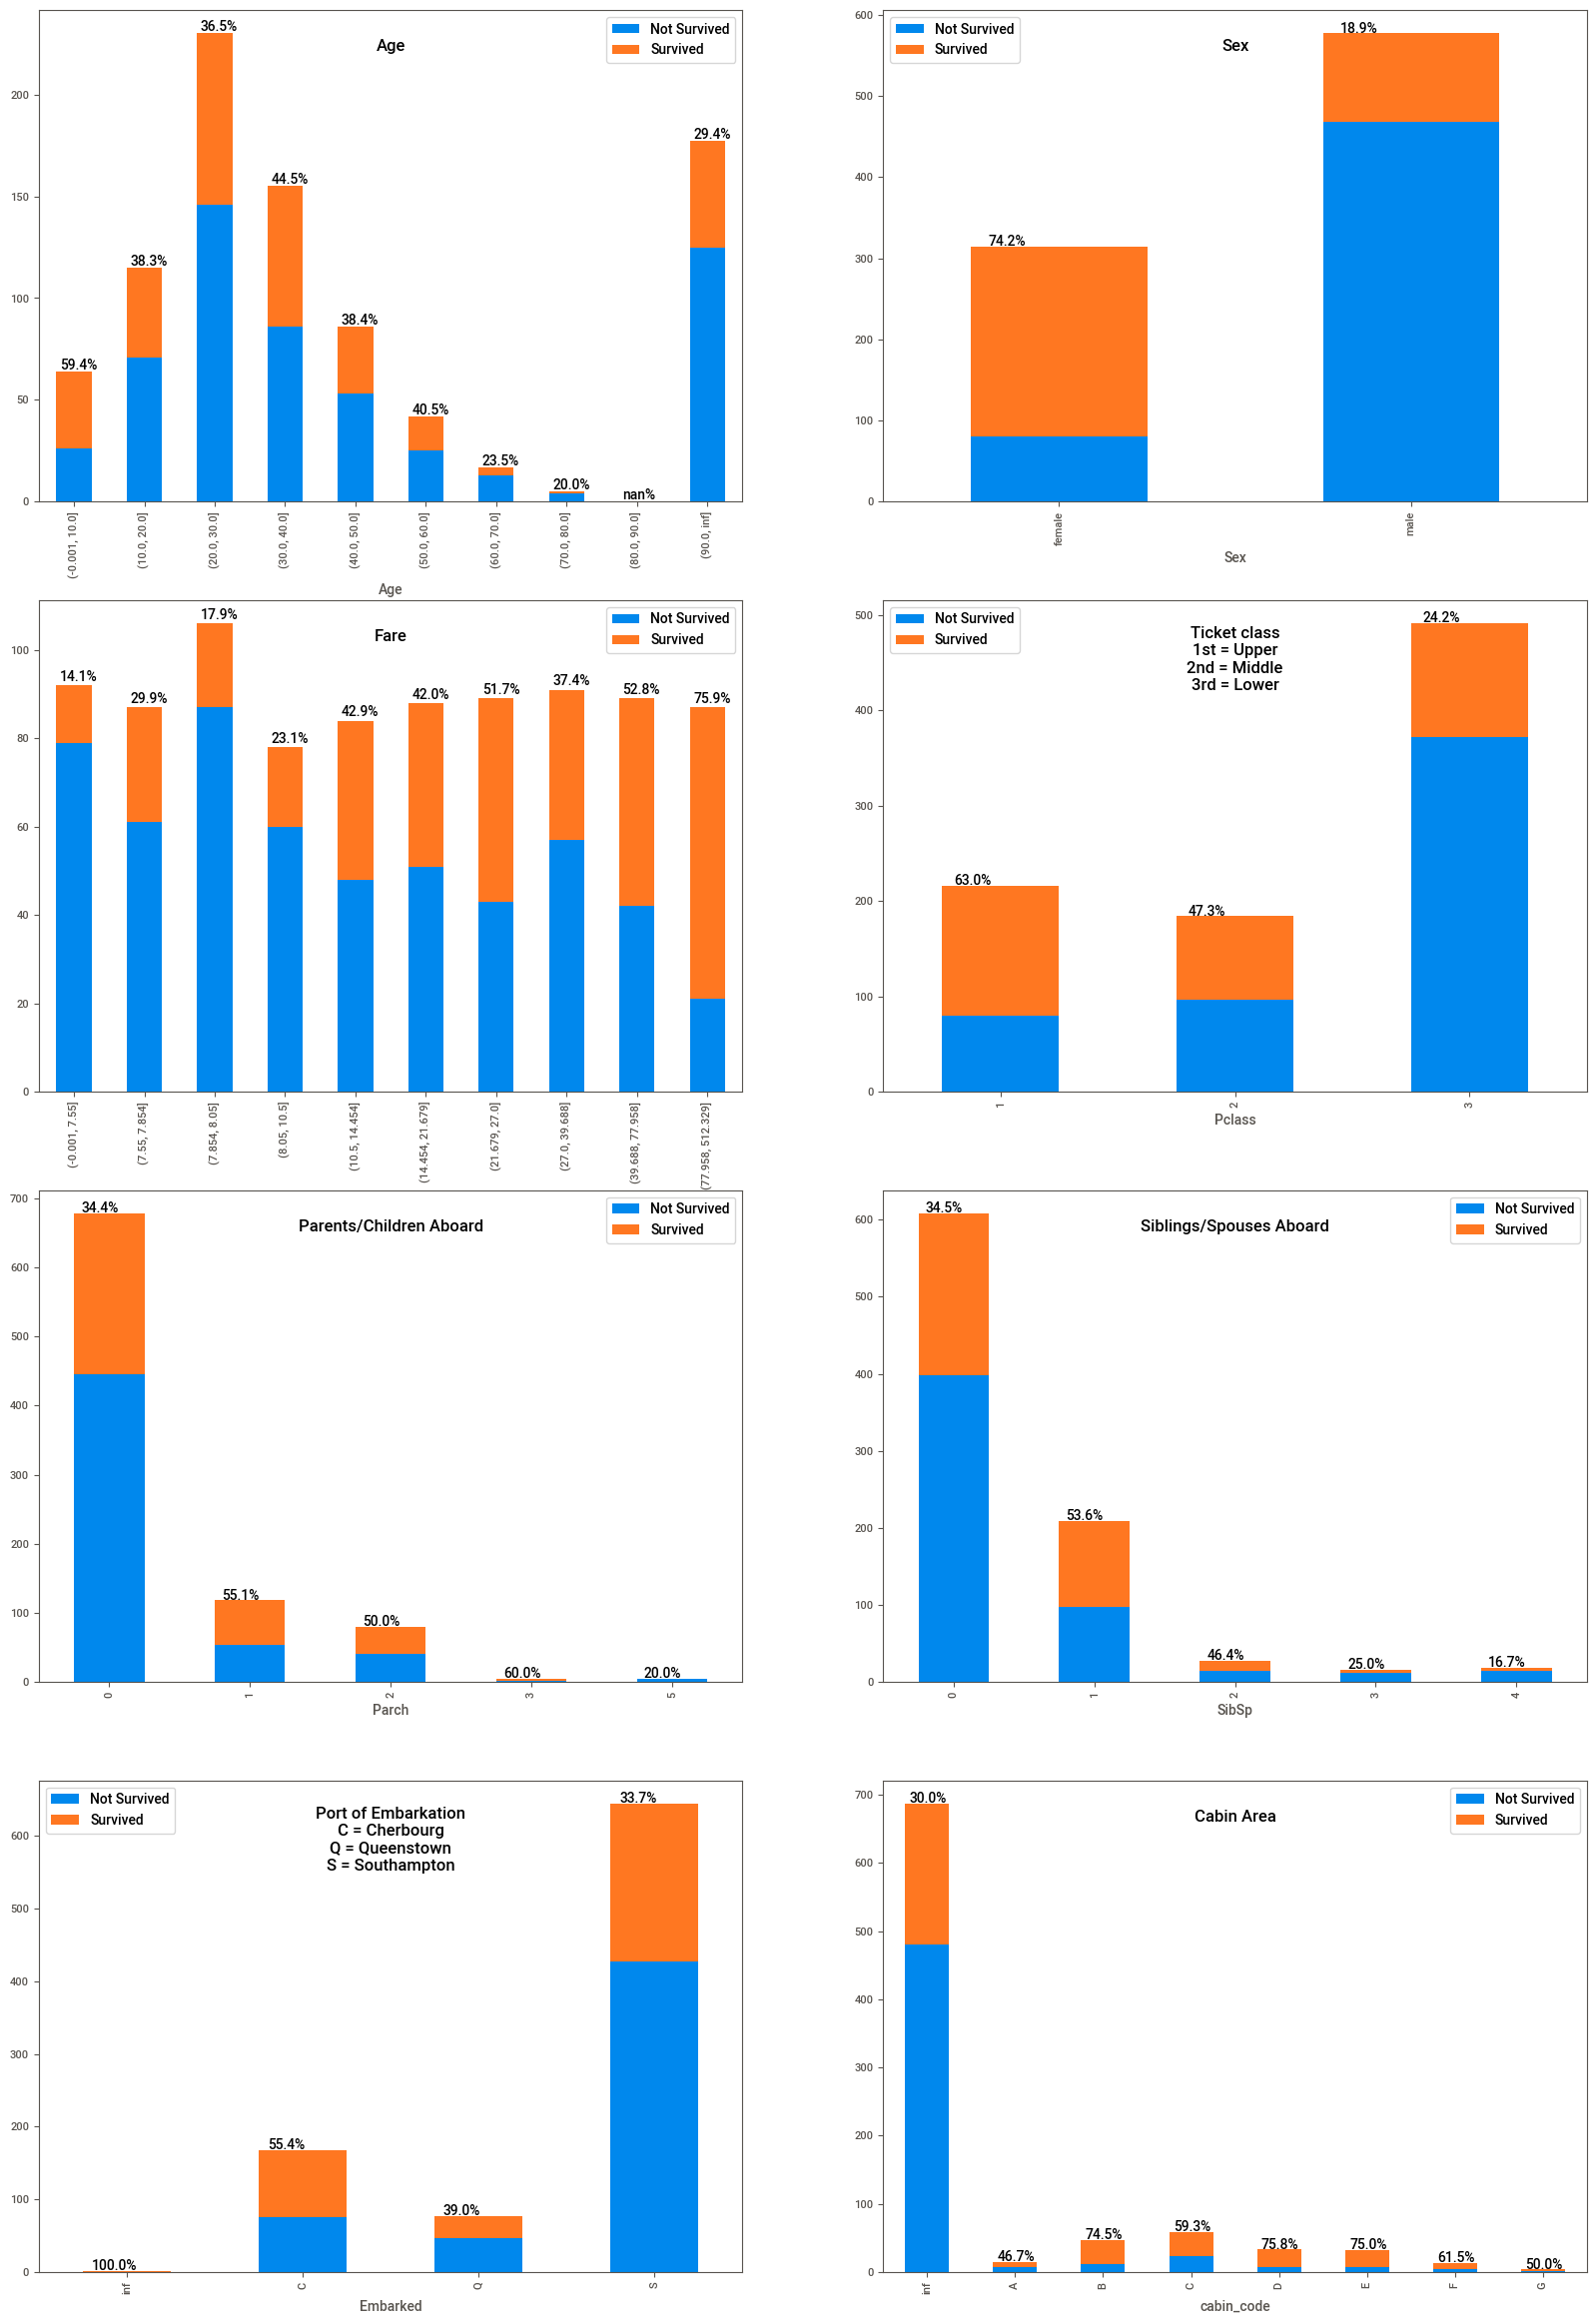

In [16]:
f, ax = plt.subplots(4, 2, sharey=False, figsize=(20,30))
drawstackchart(df,'Age',bins=list(range(0,100,10)), ax=ax[0][0])
drawstackchart(df,'Sex',ax=ax[0][1])
drawstackchart(df,'Fare',ax=ax[1][0])
drawstackchart(df,'Pclass',ax=ax[1][1],titlepos=(0.5,0.8),title='Ticket class\n1st = Upper\n2nd = Middle\n3rd = Lower')
drawstackchart(df,'Parch', ax=ax[2][0],title='Parents/Children Aboard')
drawstackchart(df,'SibSp', ax=ax[2][1],title='Siblings/Spouses Aboard')
drawstackchart(df,'Embarked', ax=ax[3][0],titlepos=(0.5,0.8),title='Port of Embarkation\nC = Cherbourg\nQ = Queenstown\nS = Southampton')
drawstackchart(df,'cabin_code',ax=ax[3][1],title='Cabin Area')
plt.show()

**Below is some observations base on the bar charts**

-   Femails and Children (Age <=10) had much high survival rate.
-   Passengers who had expensive ticket or had first class ticket were more possible to survive.
-   Passengers who had children or parents together were more possible to survive.

## ML Classifiers and datasets
Now we will use the **decision tree** modelling algorithm to train and predict the survived status for a passenger.

The decision trees implemented in scikit-learn uses only numerical features and these features are interpreted always as **continuous numeric variables**. So next, encode the string value in our dataset as numeric features that sci-kit can use for the ML algorithms. 

In [17]:
from sklearn.preprocessing import LabelEncoder
for col in ['Sex','Embarked','cabin_code']:
    df[col] = LabelEncoder().fit_transform(df[col].fillna('unknown'))
display(df)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_code
0,0,3,1,22.0,1,0,7.2500,2,8
1,1,1,0,38.0,1,0,71.2833,0,2
2,1,3,0,26.0,0,0,7.9250,2,8
3,1,1,0,35.0,1,0,53.1000,2,2
4,0,3,1,35.0,0,0,8.0500,2,8
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2,8
887,1,1,0,19.0,0,0,30.0000,2,1
888,0,3,0,NaN,1,2,23.4500,2,8
889,1,1,1,26.0,0,0,30.0000,0,2


## Metric that can show the accuracy of the model
Here we splitt the train dataset for two training and testing. The training subset is for building our model. The testing subset is for using the model on unknown data to evaluate the accuracy of the model.


In [18]:
from sklearn.model_selection import train_test_split
df2=df.replace(np.inf, np.nan)
df2 = df2.fillna(-10)
X = df2.drop("Survived", axis=1)
Y = df2["Survived"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21, stratify=Y)
X_train.shape, Y_train.shape, X_test.shape

((712, 8), (712,), (179, 8))

Use the **decision tree** modelling algorithm to train the training subset X_train, Y_train

In [19]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Model is trained. Use the testing subset to evaluate the accuracy. We will have a accuracy score between 0 to 100

In [20]:
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)
acc_decision_tree

76.54

## Conclusion
So with our dataset analysis, and modelling work, now we have a decision tree model could predict the survived status of a passenger with a **76.54%** accuracy rate.